本文研究如何保存和回复用Estimator构建的TensorFlow模型。TensorFlow提供了两种模型格式：
- 检查点，它是一种依赖于创建模型的代码格式
- SavedModel， 它是一种独立于创建模型的代码格式

## 保存部分训练的模型

Estimators 会自动的将下面两项写入磁盘：
- 检查点，训练期间创建的模型版本
- 事件文件，其中包含了TensorBoard用来创建可视化的信息
若要制定Estimator存储信息的顶级目录，则需要为Estimator构造器中的modedir参数赋值。例如，下面代码将modeldir参数设置为models/iris目录：

In [ ]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    hidden_units=[10, 10],
    n_classes=3,
    model_dir='models/iris')

假设调用了estimator的train方法，例如：

In [ ]:
classifier.train(
        input_fn=lambda:train_input_fn(train_x, train_y, batch_size=100),
                steps=200)

如下图所示，第一次调用train方法会将检查点和其他文件添加至model_dir文件夹下：
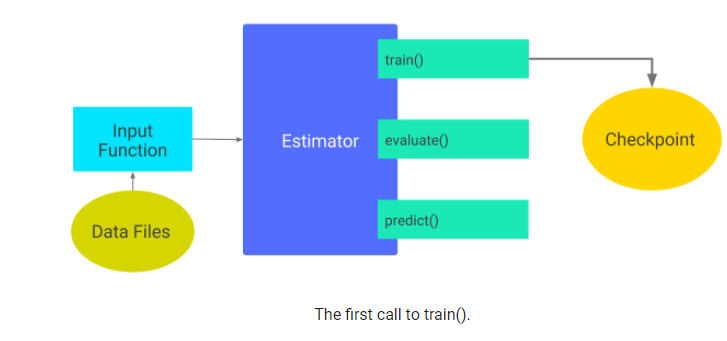

检查目录../models/iris下文件
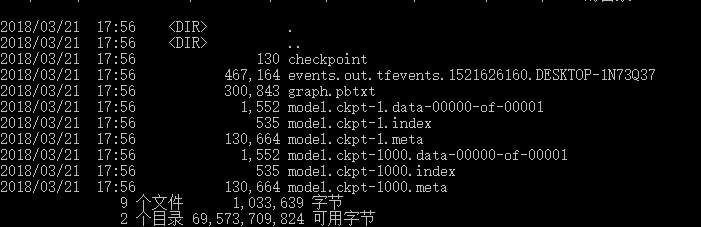

## 默认检查点目录

如果不指定model_dir参数，estimator会将检查点文件写入到Python的tempfile.mkdtemp选定的临时目录中。

In [ ]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    hidden_units=[10, 10],
    n_classes=3)

print(classifier.model_dir)

**tempfile.mkdtemp**函数会根据你的操作西痛选择一个安全的临时目录。如Windows的临时目录为：
C:\Users\ADMINI~1\AppData\Local\Temp\tmpn4q6rob4

## 检查点频率

默认情况下，estimator保存检查点文件到model_dir目录会经过以下计划：
- 每10分钟写一次检查点
- 每次estimator启动和完成时写一次检查点
- 只返回5个最近添加的检查点  

你可以通过以下步骤改变默认的计划表：
1. 创建一个**RunConfig**对象，来定义所需的时间表
2. 当初始化estimator时，将创建的**RunConfig**对象，传递给estimator的构造器中的参数**config**

例如，下面的代码将会改变检查点计划表，改为每20分钟写入一次，并且返回10个最近的检查点：

In [ ]:
my_checkpointing_config = tf.estimator.RunConfig(
    save_checkpoints_secs = 20*60,  # 每20分钟保存一次检查点
    keep_checkpoint_max = 10,       # 返回10个最近的检查点
)

classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    hidden_units=[10, 10],
    n_classes=3,
    model_dir='models/iris',
    config=my_checkpointing_config)

## 恢复模型

第一次调用estimator的trian方法时，TensorFlow会将检查点保存在model_dir目录下。随后调用estimator的train, eval 或者 predict 函数会发生以下情况：
1. estimator会执行model_fn()函数来构造模型图
2. estimator为最近的检查点中的新模型初始化权重  

换句话说，如下图所示，一旦检查点存在，每次调用train, evaluate或者predict函数时，TensorFlow就会重新构建模型。
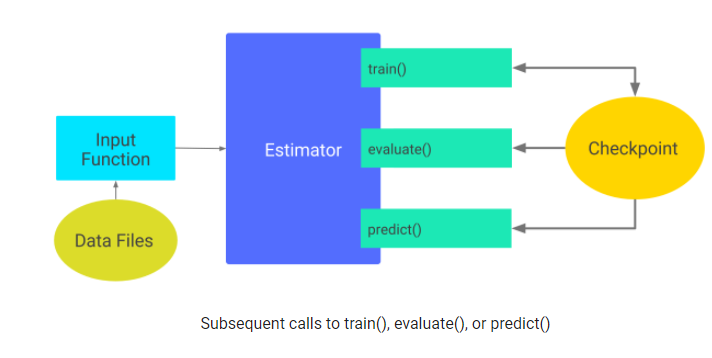

## 避免坏的恢复

只有在模型和检查点兼容的情况下，才能从检查点恢复模型的状态。例如，假设您训练了一个包含两个隐藏层的dnn分类器预估程序，每个层有10个节点：

In [ ]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[10, 10],
    n_classes=3,
    model_dir='models/iris')

classifier.train(
    input_fn=lambda:train_input_fn(train_x, train_y, batch_size=100),
        steps=200)

在训练后（即在目录models/iris创建了检查点之后），如果更改了每个隐藏层神经元的数量，由10变为20，然后尝试对模型再次训练：

In [ ]:
classifier2 = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    hidden_units=[20, 20],  # Change the number of neurons in the model.
    n_classes=3,
    model_dir='models/iris')

classifier.train(
    input_fn=lambda:train_input_fn(train_x, train_y, batch_size=100),
        steps=200)

由于检查点的状态与分类中描述的模型不兼容，再次训练会报以下错误：  

...
InvalidArgumentError (see above for traceback): tensor_name =  
dnn/hiddenlayer_1/bias/t_0/Adagrad; shape in shape_and_slice spec [10]  
does not match the shape stored in checkpoint: [20]